# 示例：轴承故障诊断

In [1]:
from torch import nn

from fastphm.data.FeatureExtractor import FeatureExtractor
from fastphm.data.labeler.FaultLabeler import FaultLabeler
from fastphm.data.loader.bearing.XJTULoader import XJTULoader
from fastphm.data.processor.RMSProcessor import RMSProcessor
from fastphm.entity.Bearing import Fault
from fastphm.model.pytorch.PytorchModel import PytorchModel
from fastphm.data.stage.BearingStageCalculator import BearingStageCalculator
from fastphm.data.stage.fpt.ThreeSigmaFPTCalculator import ThreeSigmaFPTCalculator
from fastphm.model.pytorch.basic.CNN import CNN
from fastphm.util.Plotter import Plotter

### 定义 数据加载器、特征提取器、fpt计算器、eol计算器

In [2]:
data_loader = XJTULoader('D:\\data\\dataset\\XJTU-SY_Bearing_Datasets')
feature_extractor = FeatureExtractor(RMSProcessor(data_loader.continuum))
fpt_calculator = ThreeSigmaFPTCalculator()
stage_calculator = BearingStageCalculator(data_loader.continuum, fpt_calculator)
Plotter.DPI = 80

DEBUG - 17:59:30 >> 
<< Root directory of dataset: D:\data\dataset\XJTU-SY_Bearing_Datasets
	Bearing1_1, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_1
	Bearing1_2, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_2
	Bearing1_3, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_3
	Bearing1_4, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_4
	Bearing1_5, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_5
	Bearing2_1, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_1
	Bearing2_2, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_2
	Bearing2_3, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_3
	Bearing2_4, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_4
	Bearing2_5, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_5
	Bearing3_1, location: D:\data\dataset\XJTU-SY_Bearing_Dat

### 获取原始数据、特征数据、阶段数据

In [3]:
bearing = data_loader("Bearing1_3", 'Horizontal Vibration')
feature_extractor(bearing)
stage_calculator(bearing)

INFO - 17:59:30 >> Loading data entity: Bearing1_3
INFO - 17:59:34 >> Successfully loaded data entity: Bearing1_3


### 生成训练数据

In [4]:
fault_types = [Fault.NC, Fault.OF, Fault.IF, Fault.CF]
labeler = FaultLabeler(2048, fault_types, is_onehot=False)
dataset = labeler(bearing)

### 通过其他轴承增加训练数据

In [5]:
for bearing_name in ['Bearing1_1', 'Bearing1_4', 'Bearing2_1', 'Bearing1_2', 'Bearing2_3']:
    bearing_train = data_loader(bearing_name, 'Horizontal Vibration')
    feature_extractor(bearing_train)
    stage_calculator(bearing_train)
    another_dataset = labeler(bearing_train)
    dataset.append(another_dataset)

INFO - 17:59:34 >> Loading data entity: Bearing1_1
INFO - 17:59:36 >> Successfully loaded data entity: Bearing1_1
INFO - 17:59:36 >> Loading data entity: Bearing1_4
INFO - 17:59:38 >> Successfully loaded data entity: Bearing1_4
INFO - 17:59:38 >> Loading data entity: Bearing2_1
INFO - 17:59:48 >> Successfully loaded data entity: Bearing2_1
INFO - 17:59:48 >> Loading data entity: Bearing1_2
INFO - 17:59:51 >> Successfully loaded data entity: Bearing1_2
INFO - 17:59:51 >> Loading data entity: Bearing2_3
INFO - 18:00:02 >> Successfully loaded data entity: Bearing2_3


### 划分训练集与测试集

In [6]:
train_set, test_set = dataset.split(0.7)

### 定义模型并训练

INFO - 18:00:03 >> 
<< Successfully initialized model:
	class: CNN
	device: cuda
	dtype: torch.float32
INFO - 18:00:03 >> 
<< Start training model:
	loss function: CrossEntropyLoss
	optimizer: Adam
	learning rate: 0.001
	weight decay: 0.01
	batch size: 128
DEBUG - 18:00:03 >> Epoch 1/10, Loss: 0.2627304717
DEBUG - 18:00:04 >> Epoch 2/10, Loss: 0.0955806038
DEBUG - 18:00:04 >> Epoch 3/10, Loss: 0.0776292867
DEBUG - 18:00:04 >> Epoch 4/10, Loss: 0.0697132683
DEBUG - 18:00:05 >> Epoch 5/10, Loss: 0.0611560182
DEBUG - 18:00:05 >> Epoch 6/10, Loss: 0.0553952330
DEBUG - 18:00:05 >> Epoch 7/10, Loss: 0.0541260317
DEBUG - 18:00:06 >> Epoch 8/10, Loss: 0.0550565684
DEBUG - 18:00:06 >> Epoch 9/10, Loss: 0.0512620541
DEBUG - 18:00:06 >> Epoch 10/10, Loss: 0.0414896241
INFO - 18:00:06 >> Model training completed!!!


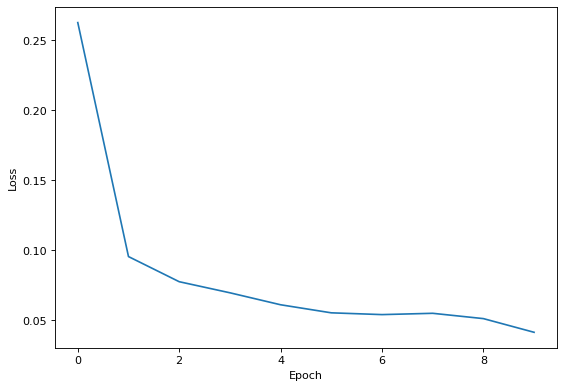

In [7]:
model = PytorchModel(CNN(2048, len(fault_types)))
model.train(train_set, 10, weight_decay=0.01, criterion=nn.CrossEntropyLoss())
Plotter.loss(model)

### 预测

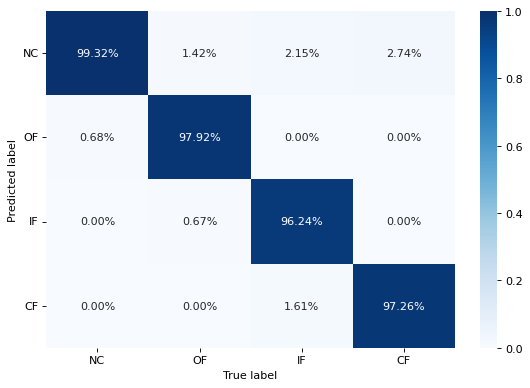

'Accuracy of Fault Diagnosis'

In [8]:
result = model.test(test_set)
Plotter.diagnosis_confusion_matrix(test_set, result, types=fault_types)